I will work with three data sets that contain $20 \times 20$ colour bitmap images of letters. In each image, the background colour, font colour, and rotation of the letter have been chosen at random.

For convenience, all data are provided in flat CSV files. The first set, in the file $\texttt{letters-train.csv}$, contains $2000$ labelled images of letters A, ..., J, stored row-wise in the following format:

$$
\begin{array}{cl}
\textbf{Column(s)} & \textbf{Description} \\
1 & \text{Label (1 = “A”, 2 = “B”, ..., 10 = “J”)} \\
2–401 & \text{Pixel values of red channel (}20 \times 20 \text{ matrix flattened to 400-dim. vector)} \\
402–801 & \text{Pixel values of green channel (ditto)} \\
802–1201 & \text{Pixel values of blue channel (ditto)} \\
\end{array}
$$

The second set, in $\texttt{letters-test-nolab.csv}$, contains $1000$ unlabelled images of letters A, ..., J. Apart from the omitted label column the format is identical to that of $\texttt{letters-train.csv}$.

Finally, the third set, in $\texttt{letters-more-nolab.csv}$, contains a further $500$ unlabelled images of letters in the same format. However, some of the letters depicted may be outside the range A, ..., J.

# 1

I will: extract the images in $\texttt{letters-train.csv}$ and delete their labels; cluster the images using $K$-means, based on the background colours of the images; determine optimal $K$ using average silhouette width; present a few images from each cluster.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

In [2]:
# Extract the images in letters-train.csv
data_train = np.loadtxt('data/letters-train.csv', delimiter=',')

image_data_train = data_train[:, 1:1201]
num_images_train = data_train.shape[0]

In [3]:
def create_image(image_data, index):
    '''Function to transform a given index of image_data into a form that can be plotted.'''
    image_red = image_data[index, 0:400].reshape(20, 20).T
    image_green = image_data[index, 400:800].reshape(20, 20).T
    image_blue = image_data[index, 800:1200].reshape(20, 20).T
    # Stack the channels to form the RGB image
    image = np.stack([image_red, image_green, image_blue], axis=-1)
    return image

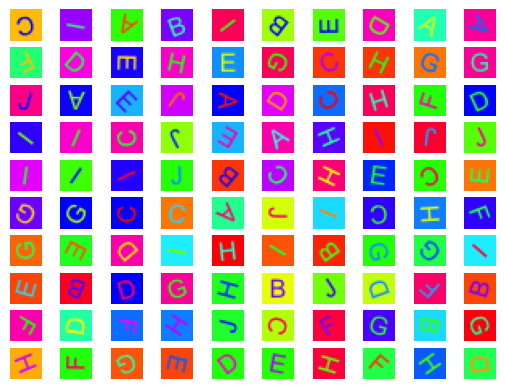

In [4]:
# Plot the first 100 images in image_data_train
plt.figure()
for i in range(100):
    image = create_image(image_data_train, i)
    # Plot the image
    plt.subplot(10, 10, (i % 10) * 10 + (i // 10) + 1)
    plt.imshow(image)
    plt.axis('off')
plt.show()

My key assumption in this question is that the background colour of an image is the most common colour in that image. Visual inspection suggests that this is a reasonable assumption.

In [5]:
def get_background_colour(image_data, index):
    '''Function to extract the most common colour from a given index of image_data.'''
    red_channel = image_data[index, 0:400]
    green_channel = image_data[index, 400:800]
    blue_channel = image_data[index, 800:1200]
    image_channels = np.column_stack((red_channel, green_channel, blue_channel))
    # Find the most common RGP triplet
    unique_triplets, counts = np.unique(image_channels, axis=0, return_counts=True)
    most_common_index = np.argmax(counts)
    background_colour = unique_triplets[most_common_index]
    return background_colour

In [6]:
# Initialise an array to store the background colours of each image in image_data_train
background_colours_train = np.zeros((num_images_train, 3))

for i in range(num_images_train):
    background_colours_train[i] = get_background_colour(image_data_train, i)

In [7]:
# Range of K values to evaluate
k_values = range(2, 11)

# Initialise a list to store average silhouette widths
silhouette_scores = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=123)
    kmeans.fit(background_colours_train)
    score = silhouette_score(background_colours_train, kmeans.labels_)
    silhouette_scores.append(score)

# Find the optimal K using average silhouette width
optimal_k = k_values[np.argmax(silhouette_scores)]
print(f'Optimal K: {optimal_k}')

Optimal K: 6


In [8]:
# Perform K-means clustering with optimal K
kmeans = KMeans(n_clusters=optimal_k, random_state=123)
kmeans.fit(background_colours_train)

# Extract cluster labels
cluster_labels = kmeans.labels_

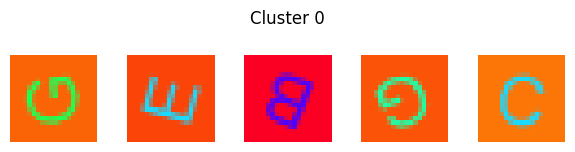

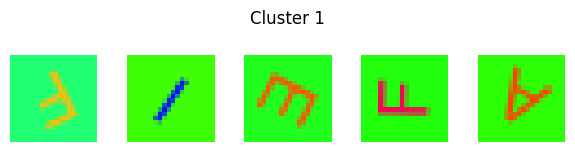

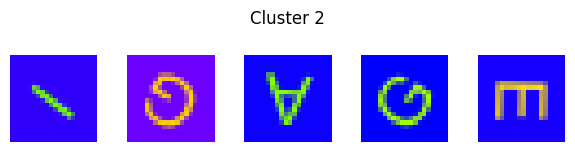

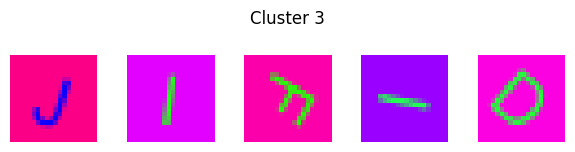

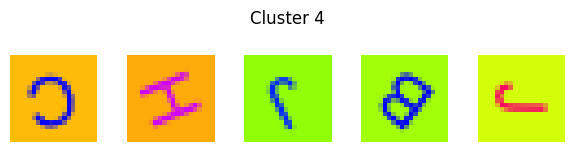

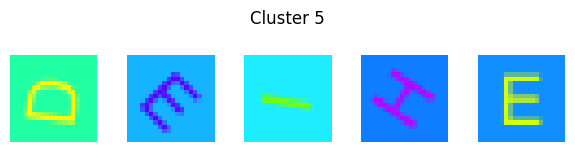

In [9]:
def plot_cluster_images(cluster_label, num_images_to_plot=5):
    '''Function to plot num_images_to_plot for a given cluster_label.'''
    cluster_indices = np.where(cluster_labels == cluster_label)[0]
    selected_indices = cluster_indices[:num_images_to_plot]
    fig, axs = plt.subplots(1, num_images_to_plot, figsize=(6, 1.5))
    plt.suptitle(f'Cluster {cluster_label}')
    for i, index in enumerate(selected_indices):
        image = create_image(image_data_train, index)
        axs[i].imshow(image)
        axs[i].axis('off')
    plt.tight_layout()
    plt.show()

# Plot 5 images from each cluster
for cluster_label in range(optimal_k):
    plot_cluster_images(cluster_label)

The first four of these clusters make sense. The background colours appear to be very similar to the human eye.

The last two make less sense. The background colours appear to be less similar to the human eye.

# 2

I will train a linear $10$-class classifier to predict the labels of the images provided in $\texttt{letters-train.csv}$. To this end, I will perform dimensionality reduction on columns $2–1201$ of the data set in order to construct suitable features for the classifier. When training the classifier, I will aim for maximal accuracy.

Employing the dimensionality reduction procedure and classifier from above, I will predict the labels of the $1000$ images in $\texttt{letters-test-nolab.csv}$.

My key idea for this question is to treat RGB as a $3$-dimensional vector space.

In [10]:
def get_scaled_distances(image_data):
    '''Function to convert image_data into a form that can be plotted as white on black.'''
    num_images = image_data.shape[0]
    red_channels = image_data[:, 0:400]
    green_channels = image_data[:, 400:800]
    blue_channels = image_data[:, 800:1200]
    # Calculate the distance of each pixel from the background colour
    distances = np.zeros((num_images, 400))
    for i in range(num_images):
        background_colour = get_background_colour(image_data, i)
        for j in range(400): # Each image has 400 pixels
            pixel_colour = np.array([red_channels[i, j], green_channels[i, j], blue_channels[i, j]])
            distance = np.linalg.norm(pixel_colour - background_colour)
            distances[i, j] = distance
    # Scale the pixel distances for each image to be between 0 and 1
    distances_scaled = np.zeros_like(distances)
    for i in range(num_images):
        min_val = np.min(distances[i])
        max_val = np.max(distances[i])
        distances_scaled[i] = (distances[i] - min_val) / (max_val - min_val)
    return distances_scaled

In [11]:
X_train = get_scaled_distances(image_data_train)
y_train = data_train[:, 0].astype(int)

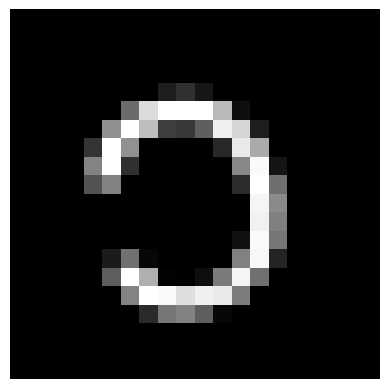

In [12]:
# Plot the first letter to check get_scaled_distances works as expected
first_image_distances = X_train[0].reshape(20, 20).T

plt.figure()
plt.imshow(first_image_distances, cmap='gray')
plt.axis('off')
plt.show()

In [13]:
# Define values of n_components for cross-validation
n_components_values = np.arange(10, 41, 5)

mean_scores = []
std_scores = []

for n_components in n_components_values:
    pca = PCA(n_components=n_components, random_state=1)
    X_train_pca = pca.fit_transform(X_train)
    model = LogisticRegression(max_iter=1000)
    # sklearn.model_selection.cross_val_score uses accuracy by default
    scores = cross_val_score(model, X_train_pca, y_train, cv=10)
    mean_scores.append(np.mean(scores))
    std_scores.append(np.std(scores))

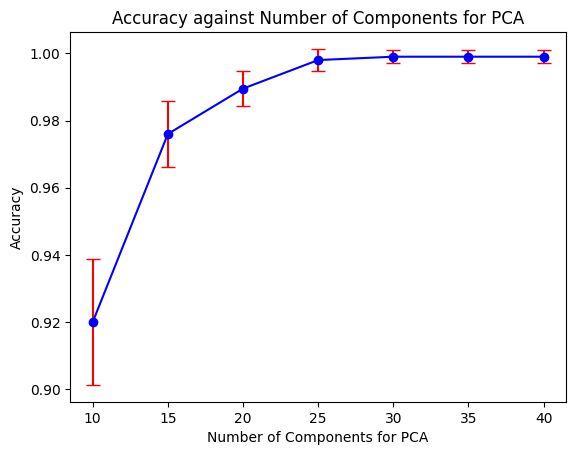

In [14]:
# Plot accuracy against n_components
plt.errorbar(n_components_values, mean_scores, yerr=std_scores, fmt='-o', color='b', ecolor='r', capsize=5)
plt.title('Accuracy against Number of Components for PCA')
plt.xlabel('Number of Components for PCA')
plt.ylabel('Accuracy')
plt.xticks(n_components_values)
plt.show()

From the above, we can see that ``n_components=30`` is optimal. When ``n_components>30``, accuracy does not improve.

In [15]:
# Perform PCA with n_components=30
pca = PCA(n_components=30)
X_train_pca = pca.fit_transform(X_train)
model = LogisticRegression(max_iter=1000)
model = model.fit(X_train_pca, y_train)

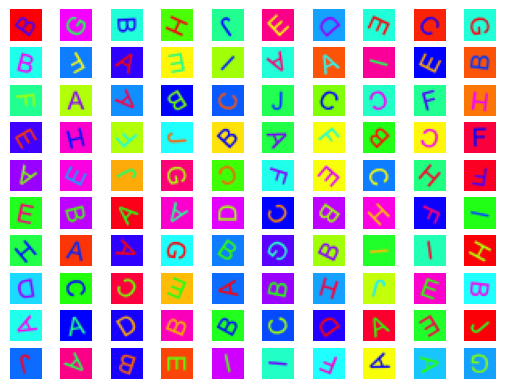

In [16]:
# Extract the images in letters-test-nolab.csv
image_data_test = np.loadtxt('data/letters-test-nolab.csv', delimiter=',')

# Plot the first 100 images in image_data_test
plt.figure()
for i in range(100):
    image = create_image(image_data_test, i)
    # Plot the image
    plt.subplot(10, 10, (i % 10) * 10 + (i // 10) + 1)
    plt.imshow(image)
    plt.axis('off')
plt.show()

In [17]:
X_test = get_scaled_distances(image_data_test)

# Use pre-fit PCA to transform X_test
X_test_pca = pca.transform(X_test)

# Predict the labels using the pre-trained LogisticRegression model
y_pred_test = model.predict(X_test_pca)

# Optionally, save predictions to a file
np.savetxt('q2.txt', y_pred_test, fmt='%d')

# 3

Using the images in $\texttt{letters-train.csv}$ as a reference set, I will detect possible anomalies, i.e., images depicting letters other than A, ..., J, among the $500$ images in $\texttt{letters-more-nolab.csv}$. I will then assess the reliability of detection by visual inspection.

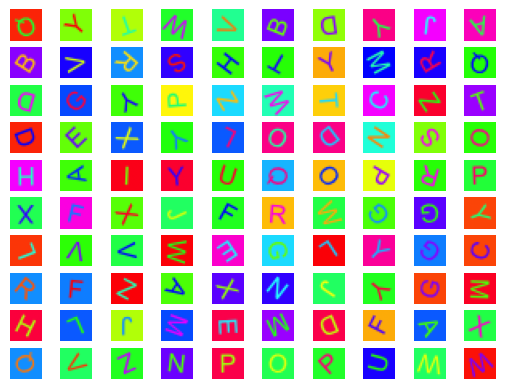

In [18]:
# Extract the images in letters-more-nolab.csv
image_data_more = np.loadtxt('data/letters-more-nolab.csv', delimiter=',')

# Plot the first 100 images in image_data_more
plt.figure()
for i in range(100):
    image = create_image(image_data_more, i)
    # Plot the image
    plt.subplot(10, 10, (i % 10) * 10 + (i // 10) + 1)
    plt.imshow(image)
    plt.axis('off')
plt.show()

I will detect possible anomalies by looking at letters with the lowest probability estimates.

In [19]:
X_more = get_scaled_distances(image_data_more)

# Use pre-fit PCA to transform X_more
X_more_pca = pca.transform(X_more)

# Predict the labels using the pre-trained LogisticRegression model
y_pred_more = model.predict(X_more_pca)

probability_estimates_more = model.predict_proba(X_more_pca)
# probability_estimates_more contains probability estimates for each class, extract the highest
max_probability_estimates_more = np.max(probability_estimates_more, axis=1)

Experimentation shows that when the probability estimate is above $0.95$, the accuracy starts to increase.

In [20]:
# Filter images where the probability estimate is below 0.95
indices_below_threshold = np.where(max_probability_estimates_more < 0.95)[0]

# Print the number of images that satisfy this criterion
print(len(indices_below_threshold))

317


My method has detected $317$ possible anomalies.

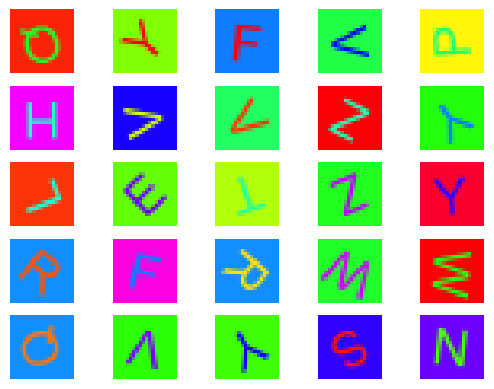

In [21]:
# Plot the first 25 images where the probability estimate is below 0.95
plt.figure()
for i, j in enumerate(indices_below_threshold[:25]):
    image = create_image(image_data_more, j)
    # Plot the image
    plt.subplot(5, 5, (i % 5) * 5 + (i // 5) + 1)
    plt.imshow(image)
    plt.axis('off')
plt.show()

Only $4$ out of the $25$ images plotted contain letters from A, ..., J, showing that my method of detecting possible anomalies is reasonably effective.